# Simple Autoencoder
- Autoencoder mnist
    - Encoder: utilize techniques from mobilenet
        - Seperable depthwise convolution
        - Residual inverted bottleneck
    - Global-pooling + flatten + linear $\rightarrow$ vector embedding $z$
    - View $(-1 , \text{dims}, 1, 1)$
- Decoder: simple upsampling+conv & no skip connection
- Học được: trick calculate batch-wise instead of pixel-wise MSE

In [1]:
import umap
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [3]:
def prepare_data(batch_size, num_workers):
    train_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root='dataset', train=True, transform=transforms.ToTensor())
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                              num_workers=num_workers, shuffle=True)
    
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, 
                             num_workers=num_workers, shuffle=True)
    
    return train_loader, test_loader

In [15]:
class DepthWise(nn.Module):
    def __init__(self, in_channels, kernel_size, stride):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=in_channels, 
            kernel_size=kernel_size,
            stride=stride, 
            groups=in_channels, 
            padding=padding,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.relu = nn.ReLU6(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class PointWise(nn.Module):
    def __init__(self, in_channels, out_channels, use_relu=False):
        super().__init__()
        self.use_relu = use_relu
        self.conv_1x1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        if self.use_relu:
            self.relu = nn.ReLU6(inplace=True)
        
    def forward(self, x):
        x = self.bn(self.conv_1x1(x))
        return self.relu(x) if self.use_relu else x
    
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, downsample):
        super().__init__()
        hidden_dim = int(round(in_channels * expand_ratio))
        self.downsample = downsample
        self.conv1 = PointWise(
            in_channels=in_channels,
            out_channels=hidden_dim,
            use_relu=True,
        )
        
        self.conv2 = DepthWise(
            in_channels=hidden_dim,
            kernel_size=3,
            stride=stride,
        )
        
        self.conv3 = PointWise(
            in_channels=hidden_dim,
            out_channels=out_channels,
            use_relu=False,
        )
        
    def forward(self, x):
        residual = x
        x = self.conv3(self.conv2(self.conv1(x)))
        return self.downsample(residual) + x if self.downsample is not None else x + residual
    
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, n):
        super().__init__()
        downsample = nn.Conv2d(in_channels=in_channels, 
                               out_channels=out_channels, 
                               kernel_size=1, stride=2, bias=False)
        
        units = []
        units.append(
            InvertedResidual(
                in_channels=in_channels, 
                out_channels=out_channels, 
                expand_ratio=expand_ratio, 
                stride=2, downsample=downsample
            )
        )
        for _ in range(1, n):
            units.append(
                InvertedResidual(
                    in_channels=out_channels, 
                    out_channels=out_channels, 
                    expand_ratio=expand_ratio, 
                    stride=1, downsample=None
                )
            )
            
        self.units = nn.Sequential(*units)
    
    def forward(self, x):
        x = self.units(x)
        return x
        

class Encoder(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.block1 = ResBlock(in_channels=32, out_channels=64, expand_ratio=2, n=num_units[0])
        self.block2 = ResBlock(in_channels=64, out_channels=128, expand_ratio=2, n=num_units[1])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.Wz = nn.Linear(in_features=128, out_features=2)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        return self.Wz(x)
    
class UpBatchReLU(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels=in_channels, 
                                       out_channels=out_channels, 
                                       kernel_size=2, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 128 * 7 * 7)
        self.block1 = UpBatchReLU(in_channels=128, out_channels=64)
        self.block2 = UpBatchReLU(in_channels=64, out_channels=32)
        self.conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)
        
    def forward(self, x):
        x = self.fc(x)  
        x = x.view(x.size(0), 128, 7, 7)
        x = self.block1(x)
        x = self.block2(x)
        x = self.conv(x)
        return x
    
class Model(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.encoder = Encoder(num_units)
        self.z = None
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.encoder(x)
        self.z = x
        x = self.decoder(x)
        return x

In [5]:
class Batch_MSE_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.reset()
        
    def reset(self):
        self.sum = 0
        self.count = 0
    
    def compute(self):
        return self.sum / self.count

    def forward(self, x_, x):
        loss = (x_ - x)**2
        loss = loss.view(loss.size(0), -1).sum(axis=1) 
        loss = loss.mean()
        self.sum += loss
        self.count += 1
        return loss

In [7]:
class Pixel_MSE_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.reset()
        self.loss_func = nn.MSELoss()
        
    def reset(self):
        self.sum = 0
        self.count = 0
    
    def compute(self):
        return self.sum / self.count

    def forward(self, x_, x):
        loss = self.loss_func(x_, x)
        self.sum += loss
        self.count += 1
        return loss

In [6]:
class Trainer:
    def __init__(self, config, model, optimizer, train_loader):
        super().__init__()
        self.config = config
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.alpha = config['alpha']
        self.epoch_interval = config["epoch_interval"],
        self.n_images = config["n_images"]
        self.mse_func = Batch_MSE_Loss()
        self.log_dict = {'loss_per_batch': [], 'loss_per_epoch': []}
        self.min_loss = 1000
        self.training_loop()
        
    def plotting(self, x_, x, epo):
        x = (x - x.min()) / (x.max() - x.min())
        x_ = (x_ - x_.min()) / (x_.max() - x_.min())

        combined_images = torch.cat((x[:10], x_[:10]), dim=0)
        image_grid = make_grid(combined_images, nrow=self.n_images)
        plt.figure(figsize=(20, 10))
        plt.imshow(image_grid.permute(1, 2, 0).detach().cpu().numpy())
        plt.axis("off")
        plt.savefig(f"{self.config['fig_path']}/epoch{epo}.png", bbox_inches='tight')
        plt.close()
        
    def return_log_dict(self):
        return self.log_dict
        
    def training_loop(self):
        self.model.compile()
        for epoch in range(self.config["epochs"]):
            print(f'Epoch {epoch+1}/{self.config["epochs"]}:')
            self.train_per_epoch(epoch+1)
    
    def train_per_epoch(self, epo):
        self.model.train()
        for x,_ in tqdm(self.train_loader):
            x = x.cuda()
            x_ = self.model(x)
            mse_loss = self.mse_func(x_, x)
            
            self.log_dict['loss_per_batch'].append(mse_loss.item())
            self.optimizer.zero_grad()
            mse_loss.backward()
            self.optimizer.step()
        
        self.plotting(x_[:self.n_images], x[:self.n_images], epo)
        self.logging()
            
    def logging(self):
        mse_loss = self.mse_func.compute()
        if mse_loss < self.min_loss:
            self.min_loss = mse_loss
            torch.save(self.model.state_dict(), self.config['save_path'])
            print("New model saved")
            
        self.log_dict['loss_per_epoch'].append(mse_loss.item())
        print(f"=== Loss: {mse_loss} ===")
        self.mse_func.reset()

In [ ]:
config = {
    "epochs": 30,
    "learning_rate": 0.001,
    "alpha": 0.5,
    "num_classes": 10,
    "n_images": 10,
    "epoch_interval": 1,
    "save_path": ".cache/models/ende2.pt",
    "fig_path": ".cache/logging/figures_ende",
}

model = Model(num_units=[2, 2]).cuda()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config["learning_rate"])
train_loader, _ = prepare_data(num_workers=1, batch_size=256)
trainer = Trainer(config=config,
                  model=model,
                  optimizer=optimizer,
                  train_loader=train_loader)
log_dict = trainer.return_log_dict()

In [8]:
model = Model(num_units=[2, 2]).cuda()
model.load_state_dict(torch.load(config["save_path"]))

<All keys matched successfully>

In [14]:
def plot_images(data_loader, model, figsize=(20, 2.5), n_images=15):
    
    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, 
                             figsize=figsize)
    
    model.eval()
    with torch.inference_mode():
        for x, _ in data_loader:
            x = x.cuda()
            h, w = x.shape[2], x.shape[3]
            x_ = model(x)[:n_images]
            x = x[:n_images]
    
    for i in range(n_images):
        for ax, img in zip(axes, [x, x_]):
            curr_img = img[i].detach().cpu()
            ax[i].imshow(curr_img.view((h, w)), cmap='gray')

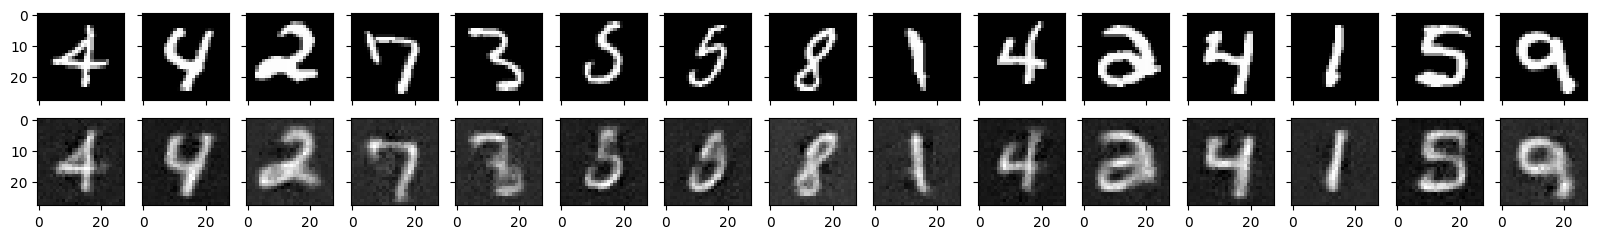

In [13]:
plot_images(data_loader=train_loader, model=model)

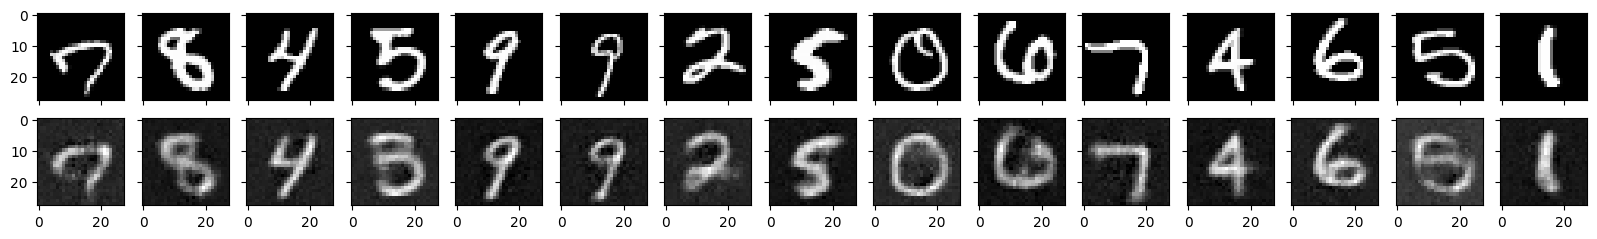

In [15]:
plot_images(data_loader=train_loader, model=model)

In [21]:
def embedding_vis(model, data_loader):
    embedding = []
    label = []
    model.eval()

    with torch.inference_mode():
        for idx, (x, y) in enumerate(data_loader):
            _ = model(x.cuda())
            label.extend(y.detach().numpy())
            embedding.extend(model.z.detach().cpu().numpy())
            if idx == 100: 
                break
            
    embedding = np.array(embedding)
    label = np.array(label)
    
    if embedding.shape[1] != 2:
        embedding = umap.UMAP().fit_transform(embedding)
        embedding.shape
    
    plt.figure(figsize=(15, 7))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=label, cmap='tab10', s=50, alpha=0.8)
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

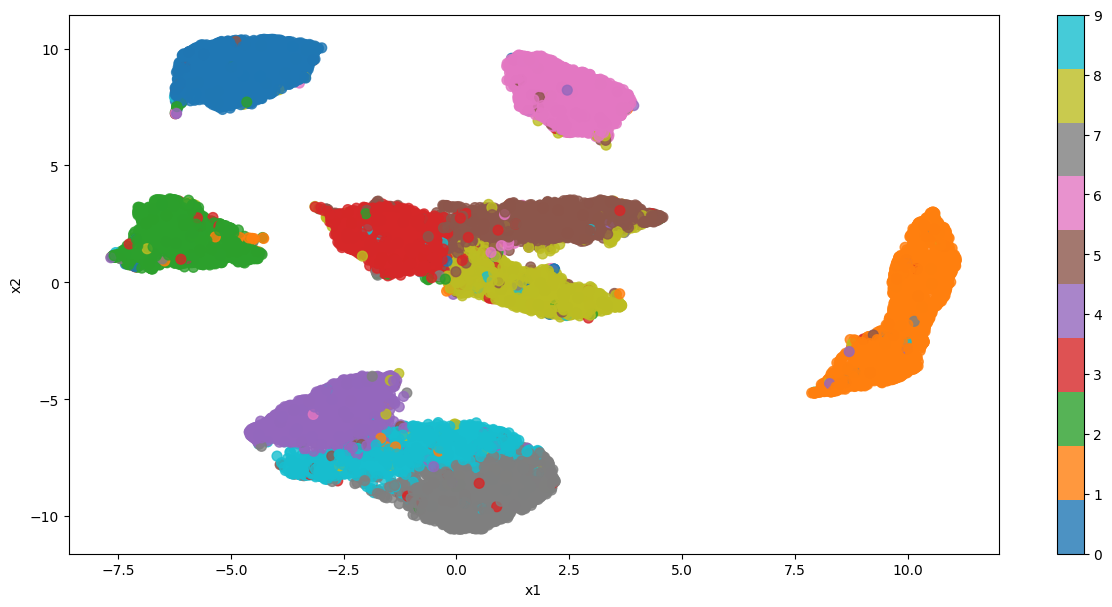

In [21]:
embedding_vis(model=model, data_loader=train_loader)

In [16]:
model = Model(num_units=[2, 2]).cuda()
model.load_state_dict(torch.load(".cache/models/ende2.pt"))

<All keys matched successfully>

In [ ]:
def plot_random_samples(model, latent_dim, n_images=10):
    model.eval()
    with torch.inference_mode():
        x = torch.randn(n_images, latent_dim).cuda()
        x_ = model.decoder(x)
        h, w = x_.shape[2], x_.shape[3]
        x_ = x_[:n_images]

    # visualization
    fig, axes = plt.subplots(nrows=1, ncols=n_images, 
                                figsize=(10, 2.5), sharey=True)
    
    for ax, img in zip(axes, x_):
        curr_img = img.detach().cpu()
        ax.imshow(curr_img.view((h, w)), cmap='gray') 
            
for i in range(10):
    plot_random_samples(model=model, latent_dim=200)
    plt.show()